In [297]:
import os
from os.path import join
import sys

# Third-party
import astropy.units as u
import matplotlib.pyplot as pl
from matplotlib import ticker
import numpy as np
pl.style.use('apw-notebook')
%matplotlib inline
from scipy.stats import gaussian_kde

import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic, dimensionless

# Custom
import biff

In [2]:
_path = os.path.abspath("../hdf5lib/")
if _path not in sys.path:
    sys.path.append(_path)
data_path = os.path.abspath("../data/")
import readsnapHDF5 as rsg

---

In [7]:
import h5py

In [296]:
with h5py.File("../data/snapdir_255/snap_255.0.hdf5", "r") as f:
    mass_table = f['Header'].attrs['MassTable']
    hubble = f['Header'].attrs['HubbleParam']
    print(f['Header'].attrs['NumPart_Total'])
    
    xyz = f['PartType1']['Coordinates'][:] / hubble * 1000.
    print(xyz.shape)
    
    m_k = mass_table[1] / hubble * np.ones(len(xyz)) # particle mass

[      0  335952   56406   28412   18071 2094257]
['NumPart_ThisFile', 'NumPart_Total', 'NumPart_Total_HighWord', 'MassTable', 'Time', 'Redshift', 'BoxSize', 'NumFilesPerSnapshot', 'Omega0', 'OmegaLambda', 'HubbleParam', 'Flag_Sfr', 'Flag_Cooling', 'Flag_StellarAge', 'Flag_Metals', 'Flag_Feedback', 'Flag_DoublePrecision', 'Flag_IC_Info']
(323243, 3)


In [257]:
med_xyz = np.median(xyz, axis=0)

# select only particles near center to do KDE
cen_r = 25. # arbitrary threshold
cen_xyz = xyz[np.sum((xyz - med_xyz[None])**2, axis=-1) < cen_r**2]

In [258]:
kde = gaussian_kde(cen_xyz[::10].T)
density = kde(cen_xyz[::10].T)
center_pos = cen_xyz[::10][density.argmax()]
centered_xyz = xyz - center_pos[None]

In [259]:
# remove any particles at (0,0,0)
del_ix, = np.where(np.all(centered_xyz == 0., axis=-1))
centered_xyz = np.delete(centered_xyz, del_ix, axis=0)
m_k = np.delete(m_k, del_ix)

In [260]:
assert len(m_k) == len(centered_xyz)

In [261]:
# maximum particle radius
r_max = 200.
r = np.sqrt(np.sum(centered_xyz**2, axis=-1))

(-200.0, 200.0)

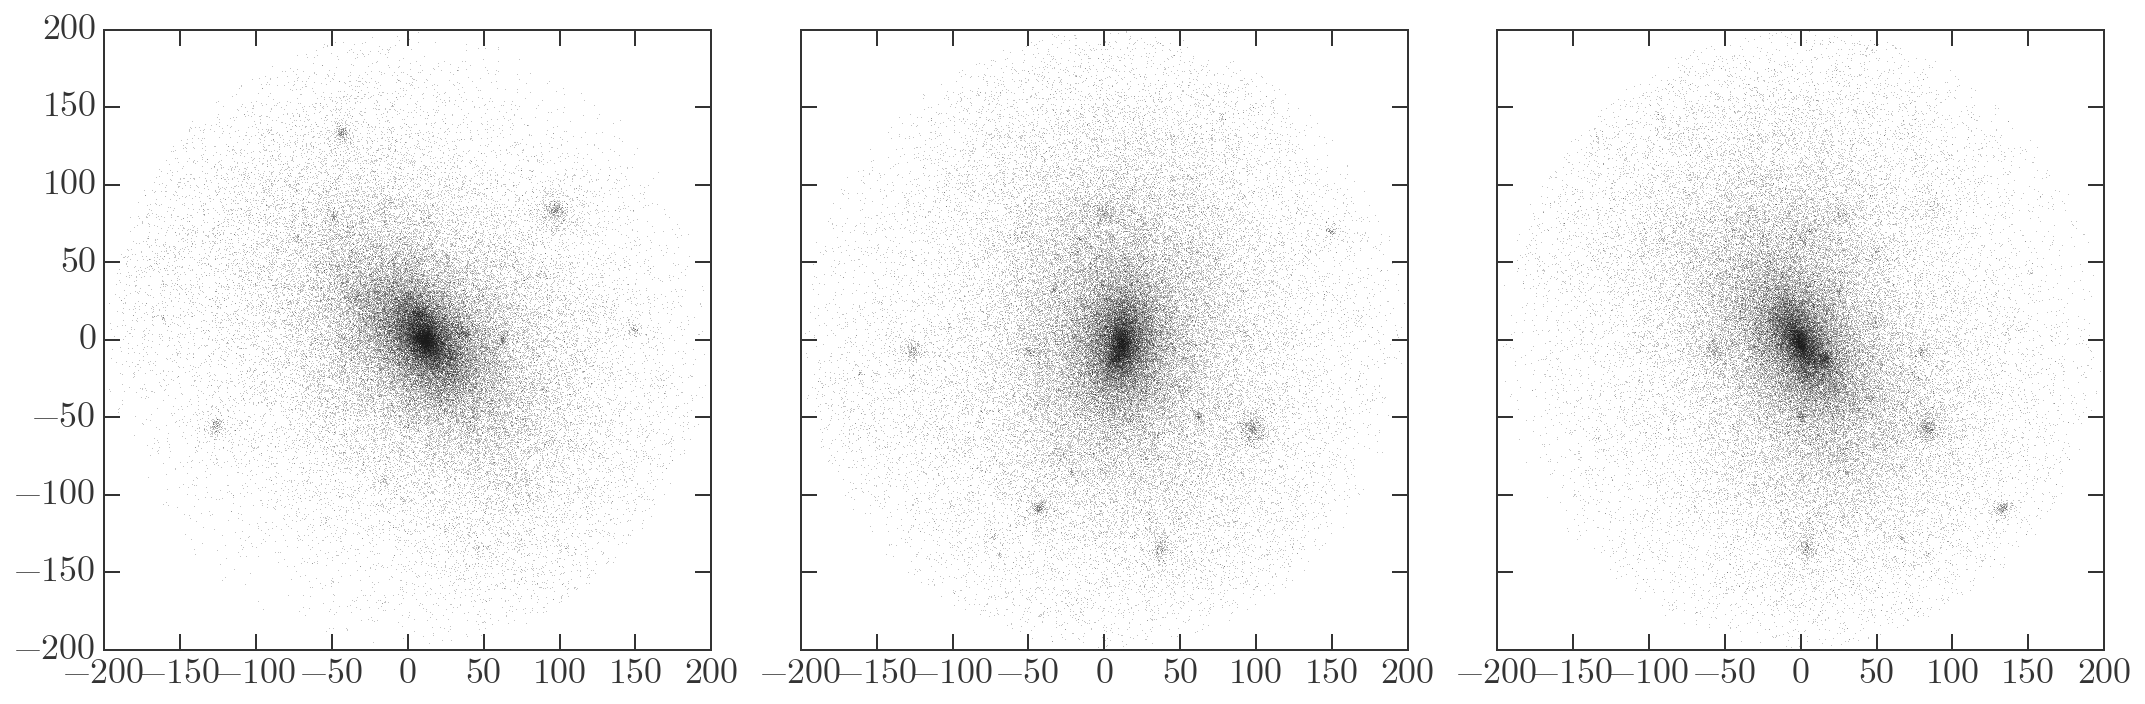

In [262]:
fig,axes = pl.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)

style = dict(linestyle='none', marker=',', alpha=0.25)

axes[0].plot(centered_xyz[r<r_max,0], centered_xyz[r<r_max,1], **style)
axes[1].plot(centered_xyz[r<r_max,0], centered_xyz[r<r_max,2], **style)
axes[2].plot(centered_xyz[r<r_max,1], centered_xyz[r<r_max,2], **style)

fig.tight_layout()

axes[0].set_xlim(-r_max,r_max)
axes[0].set_ylim(-r_max,r_max)

In [263]:
x_xT = np.einsum("ni,nj->nij", centered_xyz[r<r_max], centered_xyz[r<r_max])
I = (m_k[r<r_max,None,None] * x_xT).sum(axis=0)
I

array([[ 325994.64712537,  -74609.49722558,   -4029.92087979],
       [ -74609.49722558,  304179.12991672,  -71760.20118928],
       [  -4029.92087979,  -71760.20118928,  441683.90172177]])

In [264]:
eigval,eigvec = np.linalg.eig(I)
print("axis ratios:", np.sqrt(eigval[:2]/eigval[2]))

axis ratios: [ 0.68489842  0.88083142]


## Rotate halo so coordinates aligned with eigenvectors of inertia tensor

In [265]:
rot_xyz = np.einsum('ij,ni->nj', eigvec, centered_xyz)

(-250, 250)

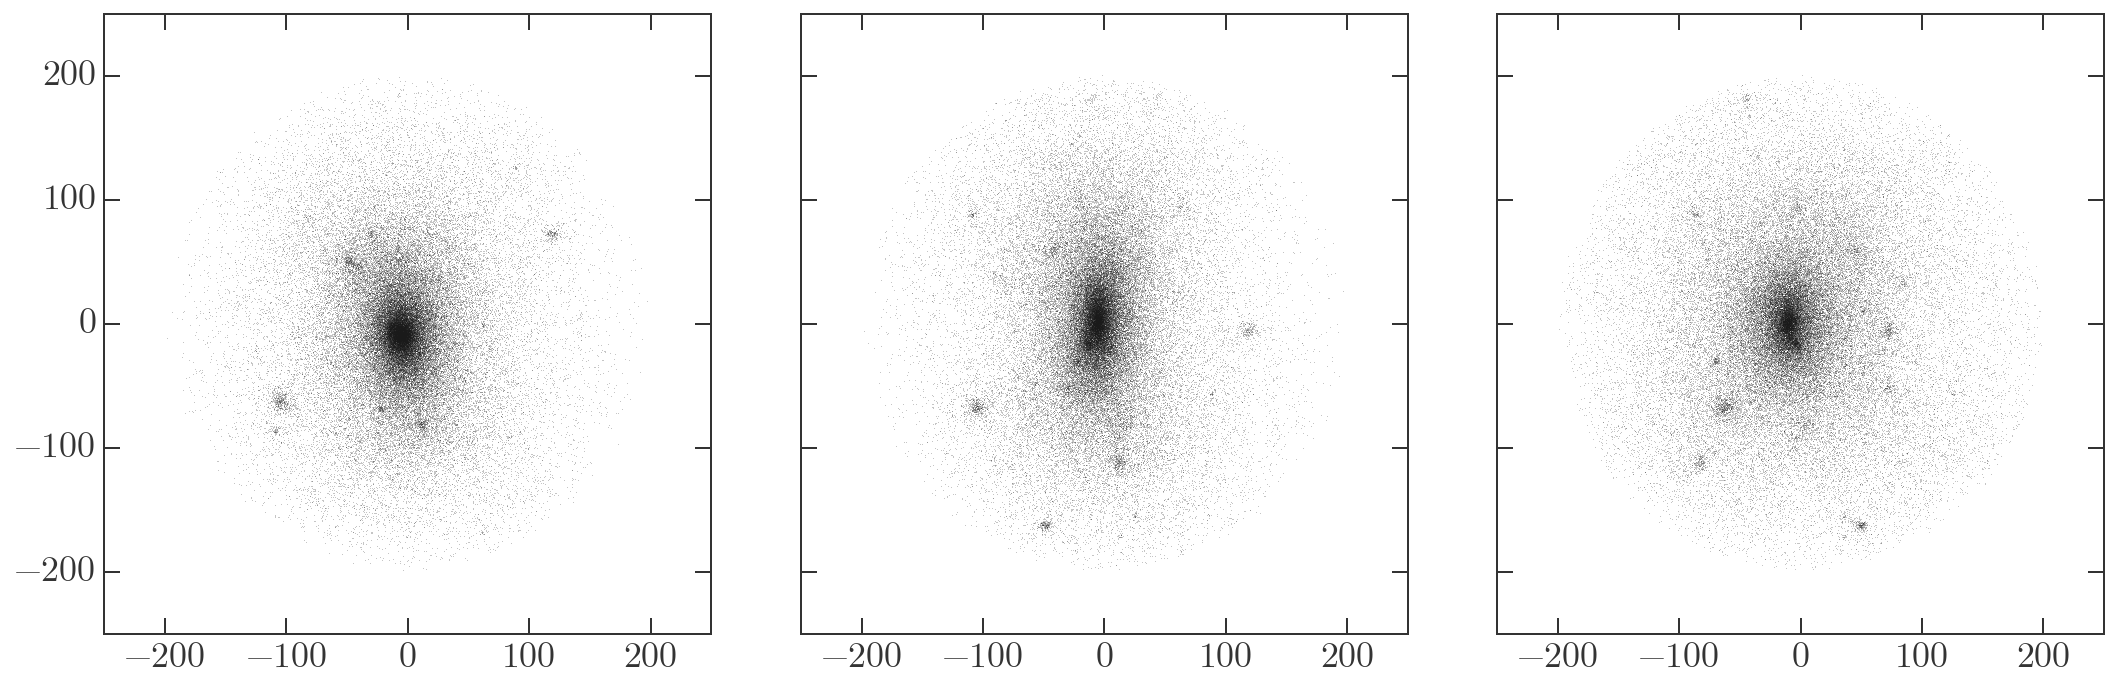

In [266]:
fig,axes = pl.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)

style = dict(linestyle='none', marker=',', alpha=0.25)

axes[0].plot(rot_xyz[r<r_max,0], rot_xyz[r<r_max,1], **style)
axes[1].plot(rot_xyz[r<r_max,0], rot_xyz[r<r_max,2], **style)
axes[2].plot(rot_xyz[r<r_max,1], rot_xyz[r<r_max,2], **style)

fig.tight_layout()

axes[0].set_xlim(-250,250)
axes[0].set_ylim(-250,250)

## Compute BFE coefficients for the halo

In [281]:
r_s = 30
S,T = biff.compute_coeffs_discrete(rot_xyz[r<r_max].astype(np.float64), 
                                   mass=m_k[r<r_max].astype(np.float64), 
                                   nmax=16, lmax=16, r_s=r_s)

In [282]:
from scipy.stats import scoreatpercentile

In [283]:
n_grid = 64
grid_max = 250.
_grid = np.zeros((3,n_grid*n_grid))
_grid[[0,1]] = np.vstack(map(np.ravel, np.meshgrid(np.linspace(-grid_max,grid_max,n_grid),
                                                   np.linspace(-grid_max,grid_max,n_grid))))

dens = biff.density(np.ascontiguousarray(_grid.T), S, T, M=m_k.sum(), r_s=r_s)

In [284]:
(dens < 0).sum(), (dens > 0).sum()

(621, 3475)

In [285]:
np.log10(dens[dens > 0.])

array([-6.08870839, -5.40532216, -5.11254344, ..., -6.13690074,
       -6.38663149, -6.82724975])

In [286]:
scoreatpercentile(np.log10(dens[dens > 0]), [1,99])

array([-6.23395016, -1.47952655])

(array([    4.,    29.,   209.,   654.,  1098.,   887.,   444.,   124.,
           20.,     6.]),
 array([-7.86131543, -7.05587595, -6.25043647, -5.44499698, -4.6395575 ,
        -3.83411801, -3.02867853, -2.22323904, -1.41779956, -0.61236007,
         0.19307941]),
 <a list of 10 Patch objects>)

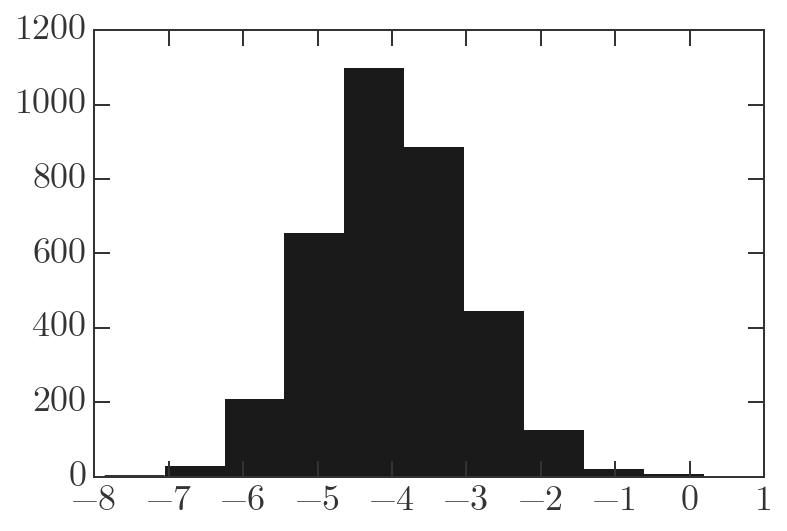

In [287]:
pl.hist(np.log10(dens[dens > 0.]))

In [288]:
def plot_density_contours(idx, S, T, grid_max=250., n_grid=64):
    _grid = np.zeros((3,n_grid*n_grid))
    _grid[idx] = np.vstack(map(np.ravel, np.meshgrid(np.linspace(-grid_max,grid_max,n_grid),
                                                     np.linspace(-grid_max,grid_max,n_grid))))

    dens = biff.density(np.ascontiguousarray(_grid.T), S, T, M=m_k.sum(), r_s=r_s)
    dens[dens < 0] = np.nan
    
    percs = np.log10([dens[dens > 0].min(), dens[dens > 0].max()])
    levels = np.logspace(percs[0], percs[1], 16)
    
    shp = (n_grid, n_grid)

    fig,ax = pl.subplots(1,1,figsize=(6,6))

#     ax.contour(_grid[idx[0]].reshape(shp), _grid[idx[1]].reshape(shp),
#                dens.reshape(shp), levels=levels,
#                colors='k', linewidths=1)
    ax.contourf(_grid[idx[0]].reshape(shp), _grid[idx[1]].reshape(shp),
                dens.reshape(shp), cmap='Blues', levels=levels,
                locator=ticker.LogLocator())

    ax.set_xlim(-grid_max, grid_max)
    ax.set_ylim(-grid_max, grid_max)
    
    ax.set_xlabel("${}$".format('xyz'[idx[0]]))
    ax.set_ylabel("${}$".format('xyz'[idx[1]]))
    
    tmp = np.array([0,1,2])
    tmp = np.delete(tmp, np.where((tmp==idx[0]) | (tmp == idx[1]))[0])
    ax.set_title("Isodensity contours at ${}=0$".format('xyz'[tmp[0]]))

    fig.tight_layout()
    
    return fig,ax

/Users/adrian/anaconda/envs/biff/lib/python3.5/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater


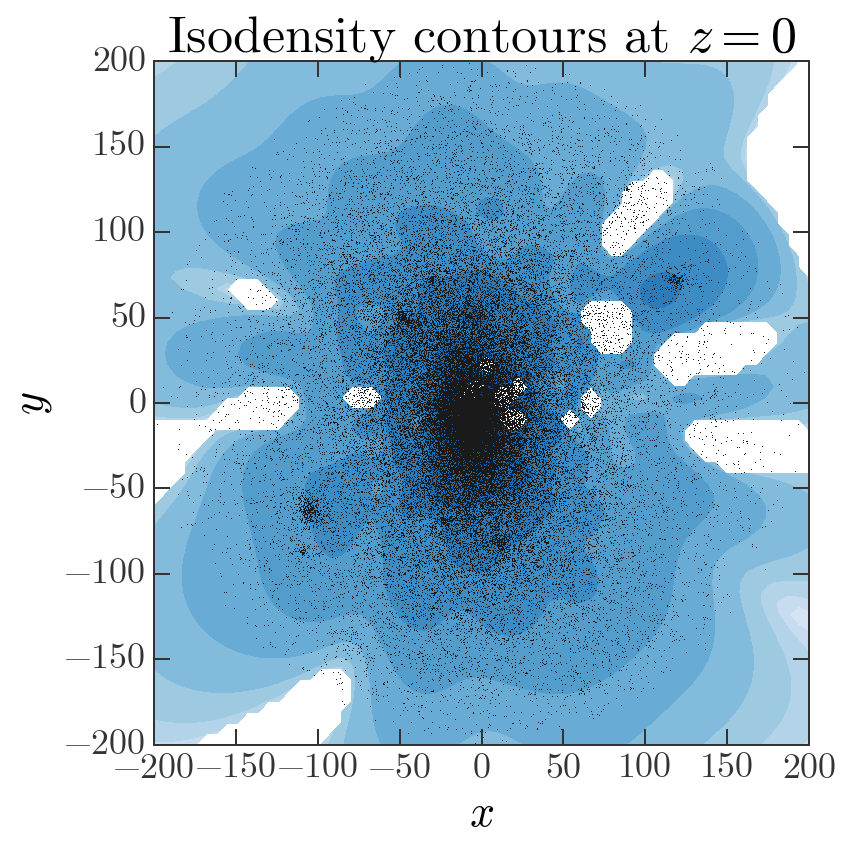

In [289]:
fig,ax = plot_density_contours([0,1], S, T, grid_max=r_max)
ax.plot(rot_xyz[r<r_max,0], rot_xyz[r<r_max,1], marker=',', linestyle='none')

/Users/adrian/anaconda/envs/biff/lib/python3.5/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater


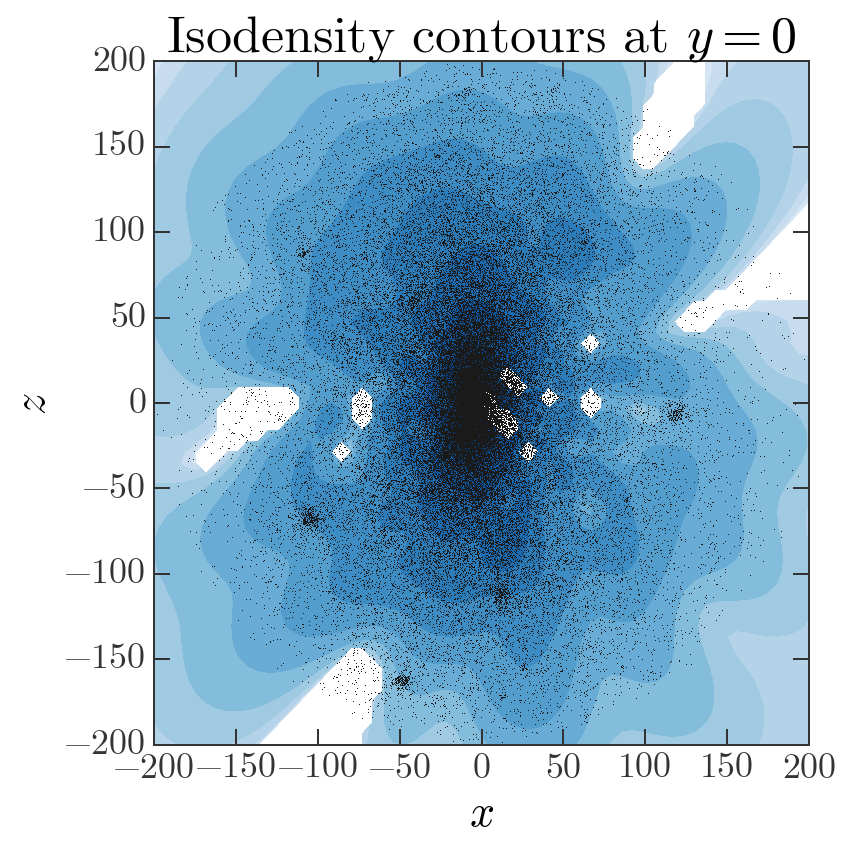

In [290]:
fig,ax = plot_density_contours([0,2], S, T, grid_max=r_max)
ax.plot(rot_xyz[r<r_max,0], rot_xyz[r<r_max,2], marker=',', linestyle='none')

/Users/adrian/anaconda/envs/biff/lib/python3.5/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater


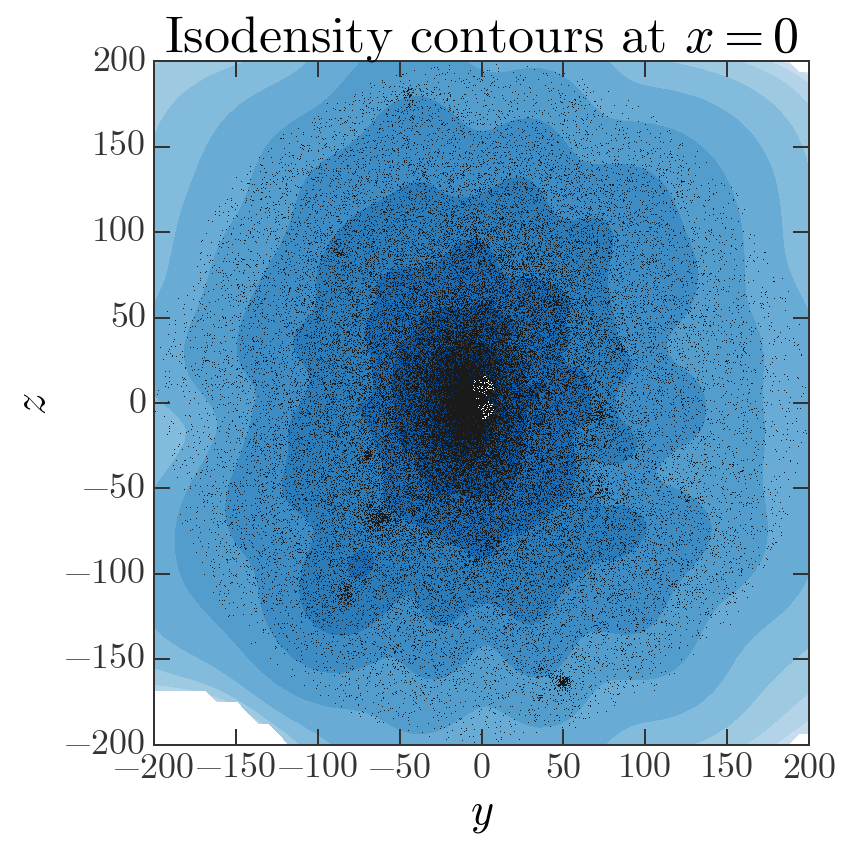

In [291]:
fig,ax = plot_density_contours([1,2], S, T, grid_max=r_max)
ax.plot(rot_xyz[r<r_max,1], rot_xyz[r<r_max,2], marker=',', linestyle='none')

In [292]:
pot = biff.SCFPotential(m=m_k.sum(), r_s=r_s, Snlm=S, Tnlm=T)

In [318]:
w0 = gd.CartesianPhaseSpacePosition(pos=[30.,0,0],
                                    vel=[0.,17.,0.])

In [325]:
orbit = pot.integrate_orbit(w0, dt=0.1, n_steps=1000) #, Integrator=gi.DOPRI853Integrator)

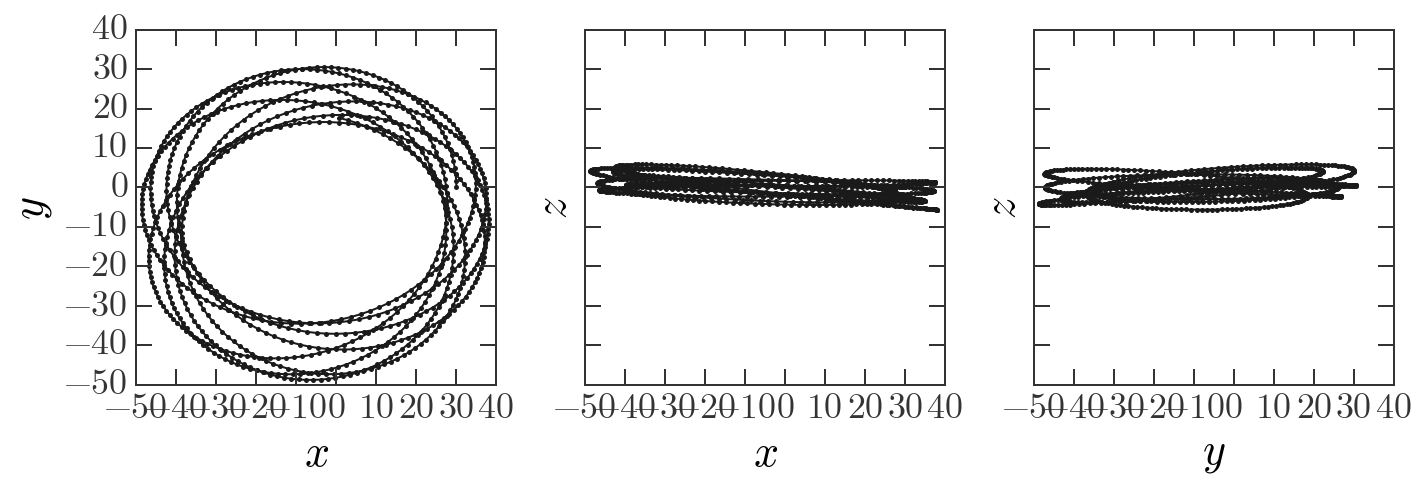

In [326]:
_ = orbit.plot(marker='.')